In [35]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import warnings
warnings.filterwarnings('ignore')

In [40]:
# 1. Загрузка и первичный анализ данных
print("1. ЗАГРУЗКА ДАННЫХ")
ds = pd.read_csv("Spotify_Youtube.csv")
print("Первые 5 строк датасета:")
ds.head()


1. ЗАГРУЗКА ДАННЫХ
Первые 5 строк датасета:


,Unnamed: 0,Artist,Url_spotify,Track,Album,Album_type,Uri,Danceability,Energy,Key,...,Url_youtube,Title,Channel,Views,Likes,Comments,Description,Licensed,official_video,Stream
0,0,Gorillaz,https://open.spotify.com/artist/3AA28KZvwAUcZu...,Feel Good Inc.,Demon Days,album,spotify:track:0d28khcov6AiegSCpG5TuT,0.818,0.705,6.0,...,https://www.youtube.com/watch?v=HyHNuVaZJ-k,Gorillaz - Feel Good Inc. (Official Video),Gorillaz,693555221.0,6220896.0,169907.0,Official HD Video for Gorillaz' fantastic trac...,True,True,1.040235e+09
1,1,Gorillaz,https://open.spotify.com/artist/3AA28KZvwAUcZu...,Rhinestone Eyes,Plastic Beach,album,spotify:track:1foMv2HQwfQ2vntFf9HFeG,0.676,0.703,8.0,...,https://www.youtube.com/watch?v=yYDmaexVHic,Gorillaz - Rhinestone Eyes [Storyboard Film] (...,Gorillaz,72011645.0,1079128.0,31003.0,The official video for Gorillaz - Rhinestone E...,True,True,3.100837e+08
2,2,Gorillaz,https://open.spotify.com/artist/3AA28KZvwAUcZu...,New Gold (feat. Tame Impala and Bootie Brown),New Gold (feat. Tame Impala and Bootie Brown),single,spotify:track:64dLd6rVqDLtkXFYrEUHIU,0.695,0.923,1.0,...,https://www.youtube.com/watch?v=qJa-VFwPpYA,Gorillaz - New Gold ft. Tame Impala & Bootie B...,Gorillaz,8435055.0,282142.0,7399.0,Gorillaz - New Gold ft. Tame Impala & Bootie B...,True,True,6.306347e+07
3,3,Gorillaz,https://open.spotify.com/artist/3AA28KZvwAUcZu...,On Melancholy Hill,Plastic Beach,album,spotify:track:0q6LuUqGLUiCPP1cbdwFs3,0.689,0.739,2.0,...,https://www.youtube.com/watch?v=04mfKJWDSzI,Gorillaz - On Melancholy Hill (Official Video),Gorillaz,211754952.0,1788577.0,55229.0,Follow Gorillaz online:\nhttp://gorillaz.com \...,True,True,4.346636e+08
4,4,Gorillaz,https://open.spotify.com/artist/3AA28KZvwAUcZu...,Clint Eastwood,Gorillaz,album,spotify:track:7yMiX7n9SBvadzox8T5jzT,0.663,0.694,10.0,...,https://www.youtube.com/watch?v=1V_xRb0x9aw,Gorillaz - Clint Eastwood (Official Video),Gorillaz,618480958.0,6197318.0,155930.0,The official music video for Gorillaz - Clint ...,True,True,6.172597e+08


In [41]:
print(f"\nРазмер датасета: {ds.shape}")


Размер датасета: (20718, 28)


In [44]:
# 2. Добавление нового атрибута (п.1 задания)
print("\n2. ДОБАВЛЕНИЕ НОВОГО АТРИБУТА")
# Создадим новый признак - общая популярность трека
# Комбинируем Stream (стримы на Spotify) и Views (просмотры на YouTube)
if 'Stream' in ds.columns and 'Views' in ds.columns:
    # Нормализуем данные перед объединением
    ds['Popularity_Score'] = (ds['Stream'].fillna(0) / ds['Stream'].max() * 0.6 + 
                              ds['Views'].fillna(0) / ds['Views'].max() * 0.4)
    print("Добавлен новый атрибут 'Popularity_Score'")
    print(f"Статистика Popularity_Score: {ds['Popularity_Score'].describe()}")


2. ДОБАВЛЕНИЕ НОВОГО АТРИБУТА
Добавлен новый атрибут 'Popularity_Score'
Статистика Popularity_Score: count    20718.000000
mean         0.027961
std          0.051990
min          0.000000
25%          0.003443
50%          0.010127
75%          0.028111
max          0.888164
Name: Popularity_Score, dtype: float64


In [45]:
# 3. "Причесывание" датасета (п.2 задания)
print("\n3. ОЧИСТКА ДАННЫХ")

# Удаляем URL-колонки и другие ненужные столбцы
url_cols = ['Url_spotify', 'Uri', 'Url_youtube', 'Title', 'Description', 'Unnamed: 0']
url_cols = [col for col in url_cols if col in ds.columns]
ds.drop(url_cols, axis=1, inplace=True, errors='ignore')

print(f"После удаления URL колонок: {ds.shape}")

# Удаляем дубликаты
initial_rows = len(ds)
ds = ds.drop_duplicates()
print(f"Удалено дубликатов: {initial_rows - len(ds)}")

# Анализ пропущенных значений
print("\nАнализ пропущенных значений:")
missing_info = pd.DataFrame({
    'Колонка': ds.columns,
    'Пропущено': ds.isnull().sum(),
    '% пропущено': (ds.isnull().sum() / len(ds) * 100).round(2)
})
print(missing_info[missing_info['Пропущено'] > 0])

# Определяем типы колонок
numeric_cols = ds.select_dtypes(include=[np.number]).columns
categorical_cols = ds.select_dtypes(exclude=[np.number]).columns

print(f"\nЧисловые колонки: {len(numeric_cols)}")
print(f"Категориальные колонки: {len(categorical_cols)}")


3. ОЧИСТКА ДАННЫХ
После удаления URL колонок: (20718, 23)
Удалено дубликатов: 0

Анализ пропущенных значений:
                           Колонка  Пропущено  % пропущено
Danceability          Danceability          2         0.01
Energy                      Energy          2         0.01
Key                            Key          2         0.01
Loudness                  Loudness          2         0.01
Speechiness            Speechiness          2         0.01
Acousticness          Acousticness          2         0.01
Instrumentalness  Instrumentalness          2         0.01
Liveness                  Liveness          2         0.01
Valence                    Valence          2         0.01
Tempo                        Tempo          2         0.01
Duration_ms            Duration_ms          2         0.01
Channel                    Channel        470         2.27
Views                        Views        470         2.27
Likes                        Likes        541         2.61
Comm


4. ВИЗУАЛИЗАЦИЯ ВЫБРОСОВ ДО ОЧИСТКИ


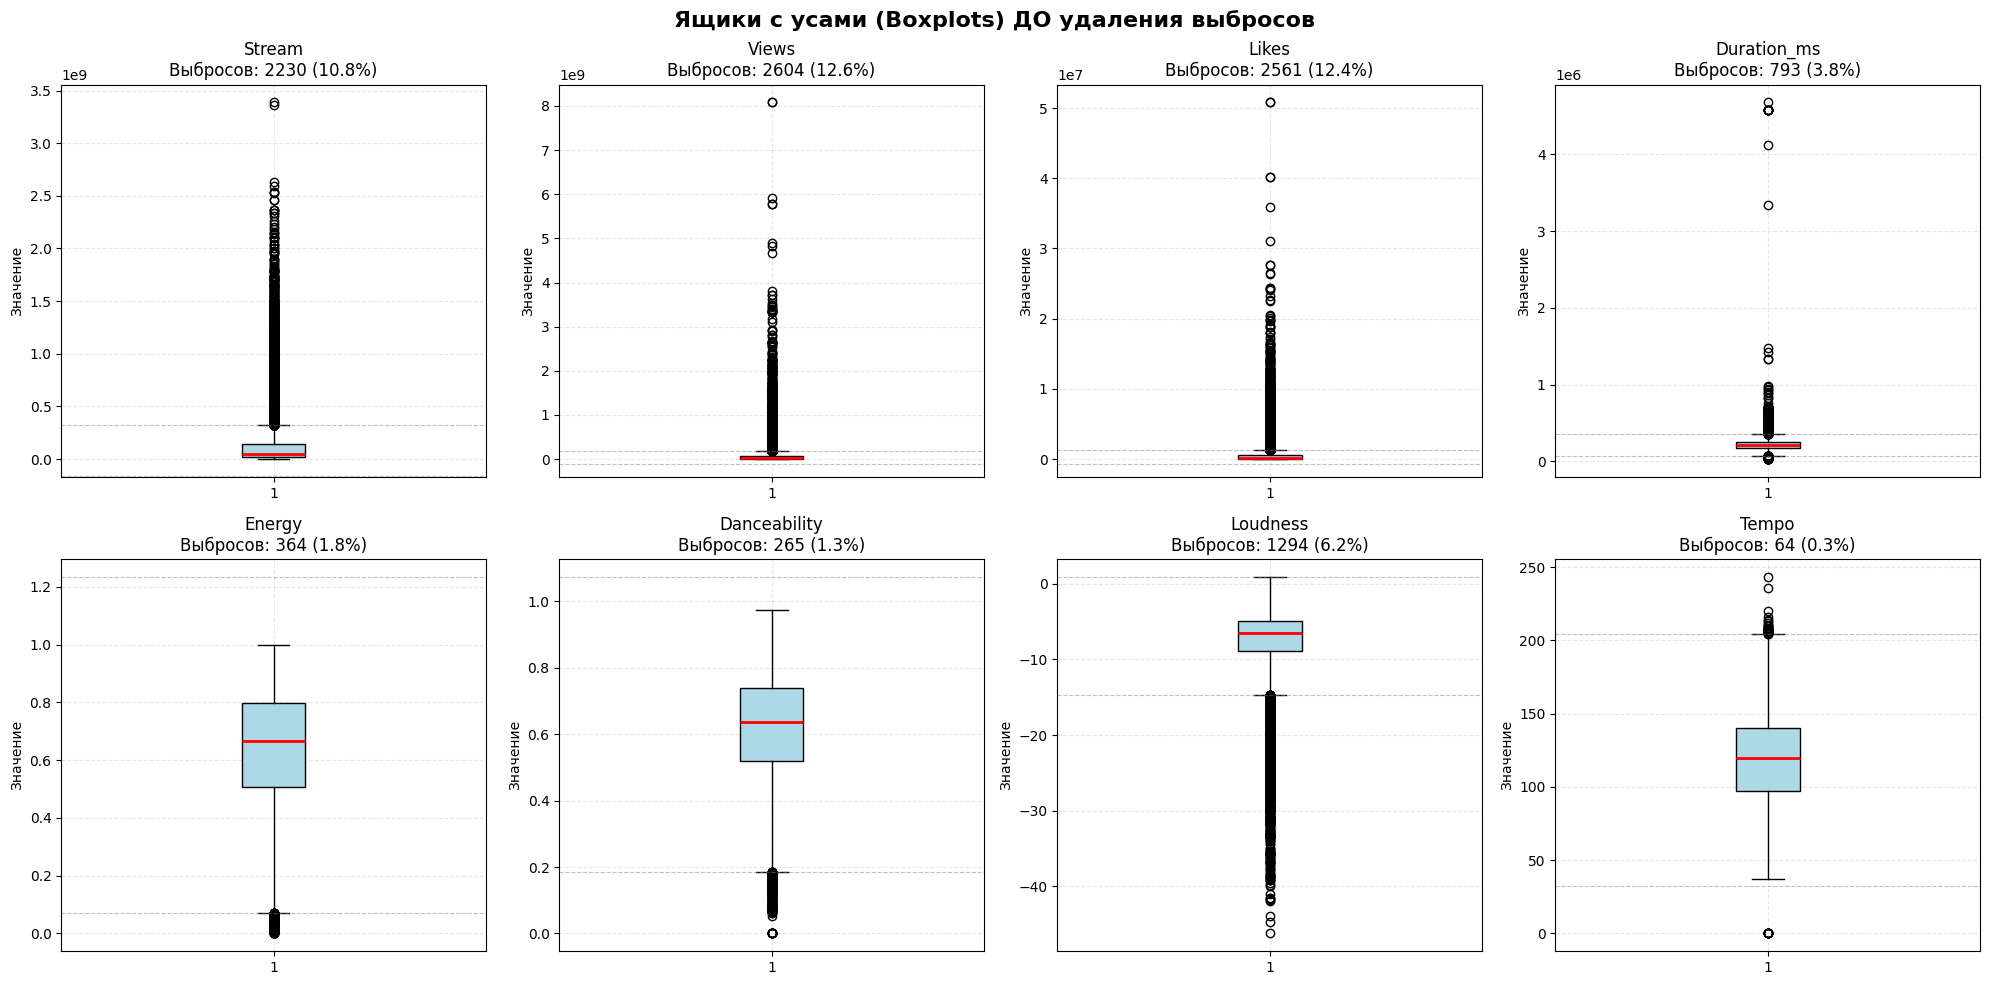

In [46]:
# 4. ВИЗУАЛИЗАЦИЯ ЯЩИКОВ С УСАМИ ДО УДАЛЕНИЯ ВЫБРОСОВ
print("\n4. ВИЗУАЛИЗАЦИЯ ВЫБРОСОВ ДО ОЧИСТКИ")

# Выбираем ключевые числовые признаки для анализа
key_numeric_cols = ['Stream', 'Views', 'Likes', 'Duration_ms', 
                    'Energy', 'Danceability', 'Loudness', 'Tempo']
key_numeric_cols = [col for col in key_numeric_cols if col in ds.columns]

# Визуализация ящиков с усами для выбранных признаков до очистки
fig, axes = plt.subplots(2, 4, figsize=(20, 10))
fig.suptitle('Ящики с усами (Boxplots) ДО удаления выбросов', fontsize=16, fontweight='bold')
    
axes = axes.flatten()
    
for idx, col in enumerate(key_numeric_cols):
    if idx < len(axes):
        # Статистика для отображения
        Q1 = ds[col].quantile(0.25)
        Q3 = ds[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        outliers_count = ((ds[col] < lower_bound) | (ds[col] > upper_bound)).sum()
            
        # Создаем boxplot
        bp = axes[idx].boxplot(ds[col].dropna(), vert=True, patch_artist=True)
            
        # Настройка внешнего вида
        bp['boxes'][0].set_facecolor('lightblue')
        bp['medians'][0].set_color('red')
        bp['medians'][0].set_linewidth(2)
            
        axes[idx].set_title(f'{col}\nВыбросов: {outliers_count} ({outliers_count/len(ds)*100:.1f}%)')
        axes[idx].set_ylabel('Значение')
        axes[idx].grid(True, alpha=0.3, linestyle='--')
            
        # Добавляем аннотации для границ
        axes[idx].axhline(y=lower_bound, color='gray', linestyle='--', alpha=0.5, linewidth=0.8)
        axes[idx].axhline(y=upper_bound, color='gray', linestyle='--', alpha=0.5, linewidth=0.8)
    
# Скрываем неиспользуемые subplots
for idx in range(len(key_numeric_cols), len(axes)):
    axes[idx].set_visible(False)
    
plt.tight_layout()
plt.show()

In [47]:
# 5. Обработка выбросов и пропущенных значений
print("\n5. ОБРАБОТКА ВЫБРОСОВ И ПРОПУЩЕННЫХ ЗНАЧЕНИЙ")
    
# Обработка числовых данных
if len(numeric_cols) > 0:
    # Заполняем пропуски медианными значениями
    numeric_imputer = SimpleImputer(strategy='median')
    ds_numeric_filled = pd.DataFrame(
        numeric_imputer.fit_transform(ds[numeric_cols]),
        columns=numeric_cols,
        index=ds.index
    )
        
    # Функция для удаления выбросов по методу IQR
    def remove_outliers_iqr(df, columns):
        df_clean = df.copy()
        for col in columns:
            Q1 = df_clean[col].quantile(0.25)
            Q3 = df_clean[col].quantile(0.75)
            IQR = Q3 - Q1
            lower_bound = Q1 - 1.5 * IQR
            upper_bound = Q3 + 1.5 * IQR
                
            # Отмечаем выбросы
            outliers_mask = (df_clean[col] < lower_bound) | (df_clean[col] > upper_bound)
            df_clean = df_clean[~outliers_mask]
            
        return df_clean
        
    # Удаляем выбросы только из ключевых числовых колонок
    if key_numeric_cols:
        initial_size = len(ds_numeric_filled)
        ds_numeric_clean = remove_outliers_iqr(ds_numeric_filled, key_numeric_cols)
        outliers_removed = initial_size - len(ds_numeric_clean)
        print(f"Удалено выбросов: {outliers_removed} ({outliers_removed/initial_size*100:.2f}%)")
            
        # Обновляем основной датафрейм
        ds_clean = ds.loc[ds_numeric_clean.index].copy()
        for col in numeric_cols:
            ds_clean[col] = ds_numeric_clean[col]
            
        print(f"Размер после очистки: {ds_clean.shape}")
            


5. ОБРАБОТКА ВЫБРОСОВ И ПРОПУЩЕННЫХ ЗНАЧЕНИЙ
Удалено выбросов: 7412 (35.78%)
Размер после очистки: (13306, 23)



6. ВИЗУАЛИЗАЦИЯ ЯЩИКОВ С УСАМИ ПОСЛЕ ОЧИСТКИ


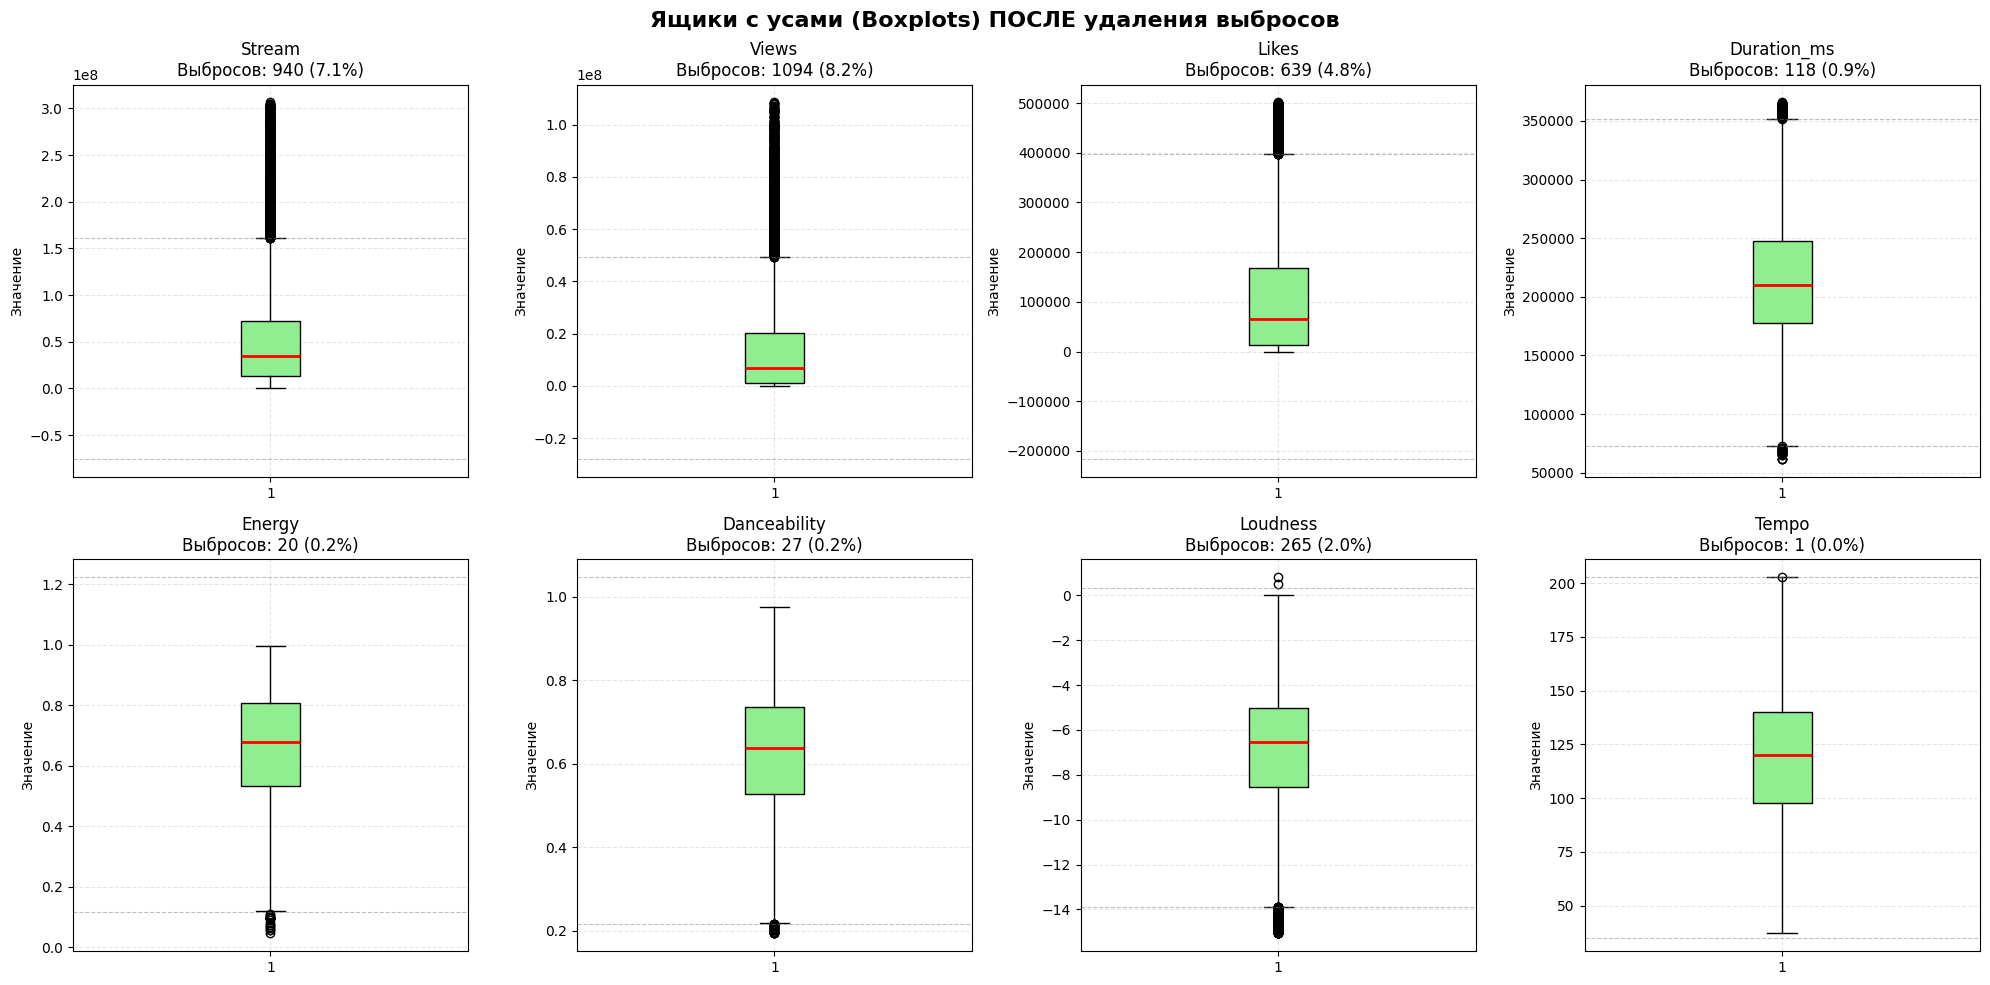

In [49]:
# 6. ВИЗУАЛИЗАЦИЯ ЯЩИКОВ С УСАМИ ПОСЛЕ УДАЛЕНИЯ ВЫБРОСОВ
print("\n6. ВИЗУАЛИЗАЦИЯ ЯЩИКОВ С УСАМИ ПОСЛЕ ОЧИСТКИ")
            
fig, axes = plt.subplots(2, 4, figsize=(20, 10))
fig.suptitle('Ящики с усами (Boxplots) ПОСЛЕ удаления выбросов', fontsize=16, fontweight='bold')
            
axes = axes.flatten()
            
for idx, col in enumerate(key_numeric_cols):
    if idx < len(axes):
        # Статистика для отображения
        Q1 = ds_clean[col].quantile(0.25)
        Q3 = ds_clean[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        outliers_count = ((ds_clean[col] < lower_bound) | (ds_clean[col] > upper_bound)).sum()
                    
        # Создаем boxplot
        bp = axes[idx].boxplot(ds_clean[col].dropna(), vert=True, patch_artist=True)
                    
        # Настройка внешнего вида (другой цвет для сравнения)
        bp['boxes'][0].set_facecolor('lightgreen')
        bp['medians'][0].set_color('red')
        bp['medians'][0].set_linewidth(2)
                    
        axes[idx].set_title(f'{col}\nВыбросов: {outliers_count} ({outliers_count/len(ds_clean)*100:.1f}%)')
        axes[idx].set_ylabel('Значение')
        axes[idx].grid(True, alpha=0.3, linestyle='--')
                    
        # Добавляем аннотации для границ
        axes[idx].axhline(y=lower_bound, color='gray', linestyle='--', alpha=0.5, linewidth=0.8)
        axes[idx].axhline(y=upper_bound, color='gray', linestyle='--', alpha=0.5, linewidth=0.8)
            
# Скрываем неиспользуемые subplots
for idx in range(len(key_numeric_cols), len(axes)):
    axes[idx].set_visible(False)
            
plt.tight_layout()
plt.show()


7. СРАВНИТЕЛЬНАЯ ВИЗУАЛИЗАЦИЯ ДО И ПОСЛЕ ОЧИСТКИ


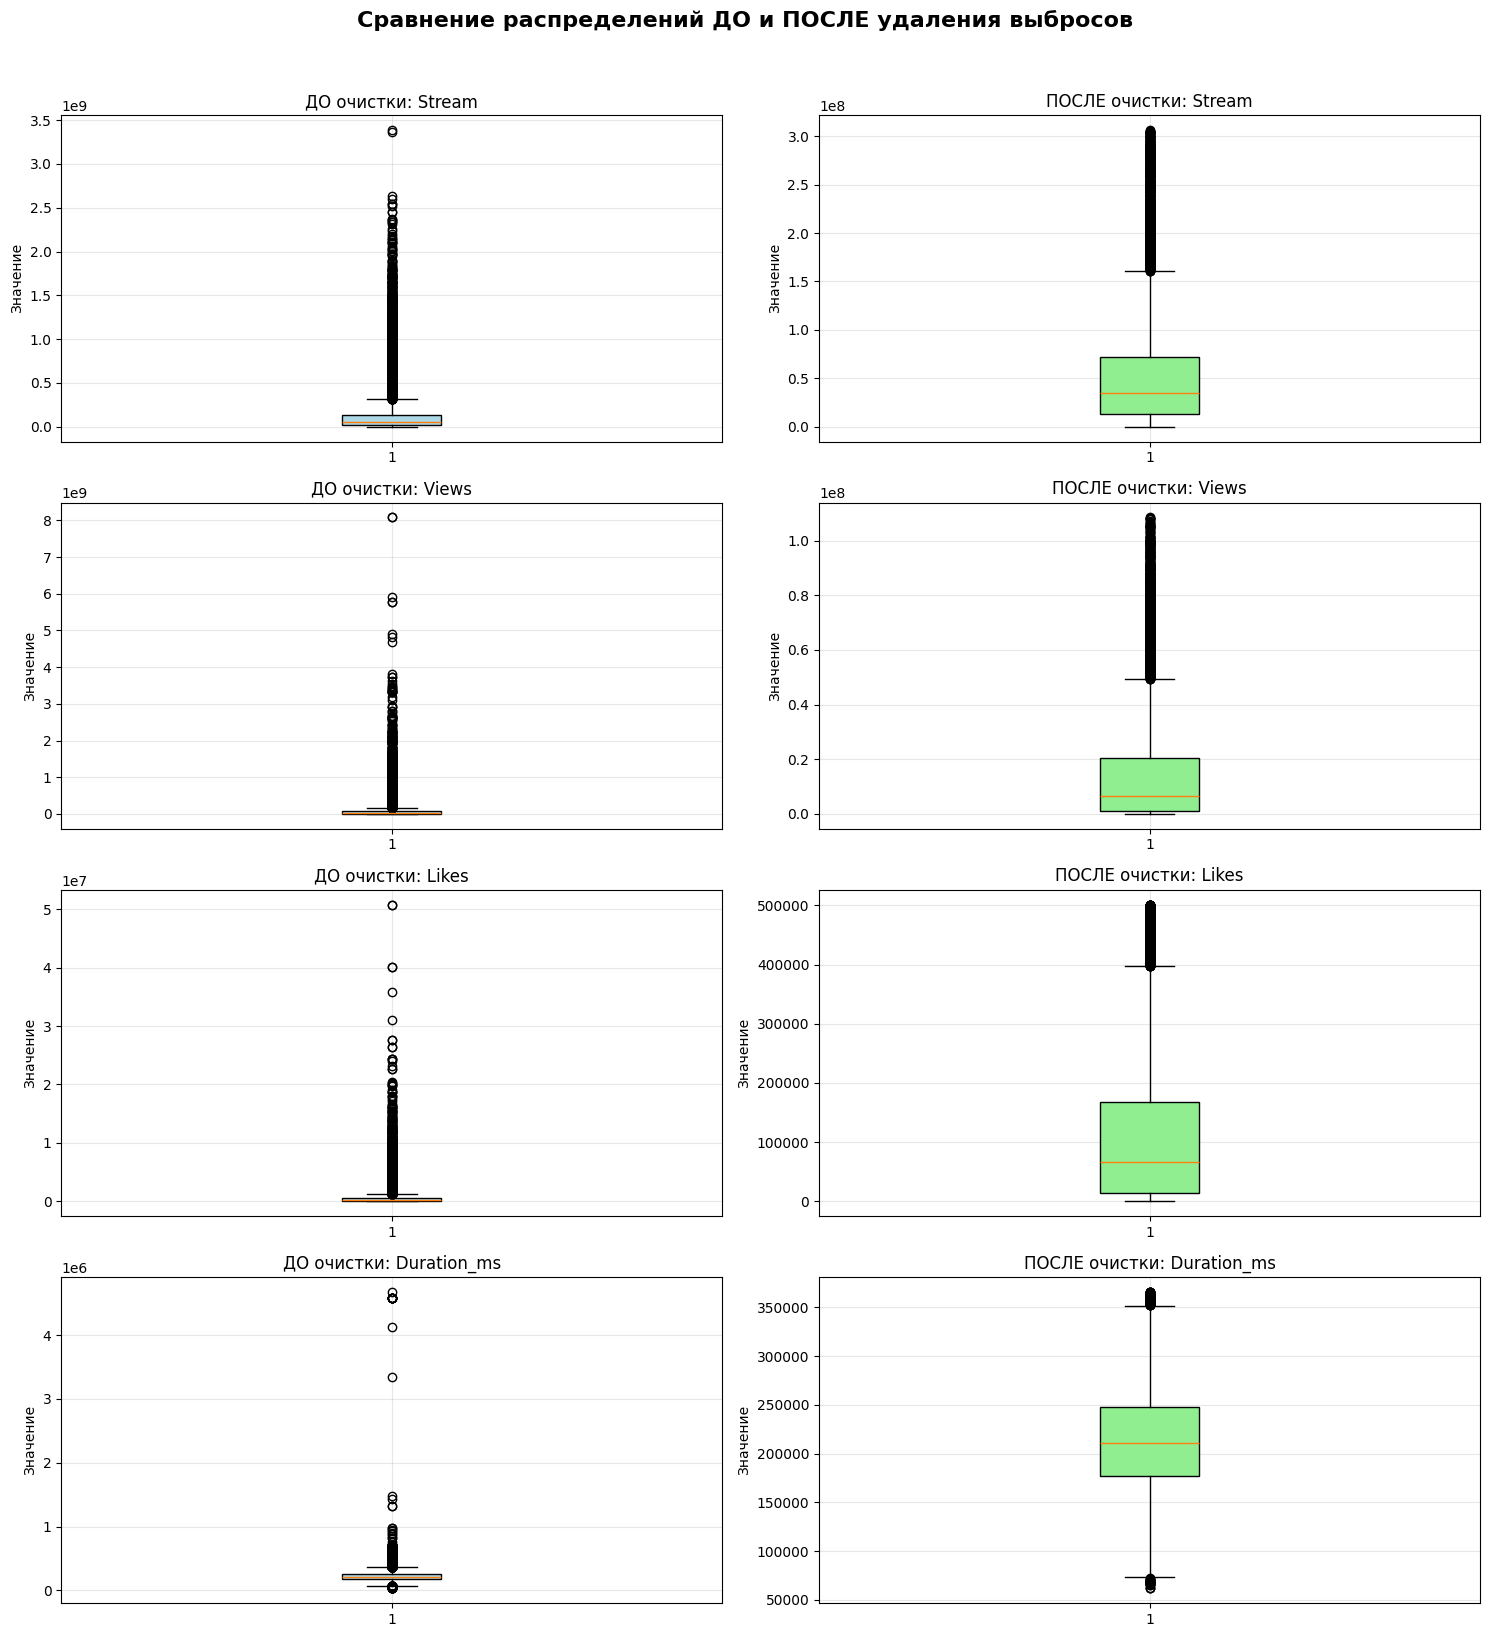


Статистика удаления выбросов по признакам:
------------------------------------------------------------
Признак              Выбросов до     Выбросов после  Удалено % 
------------------------------------------------------------
Stream               2230            940             6.23%
Views                2604            1094            7.29%
Likes                2561            639             9.28%
Duration_ms          793             118             3.26%
Energy               364             20              1.66%
Danceability         265             27              1.15%
Loudness             1294            265             4.97%
Tempo                64              1               0.30%
------------------------------------------------------------


In [50]:
 # 7. СРАВНИТЕЛЬНАЯ ВИЗУАЛИЗАЦИЯ ДО И ПОСЛЕ
print("\n7. СРАВНИТЕЛЬНАЯ ВИЗУАЛИЗАЦИЯ ДО И ПОСЛЕ ОЧИСТКИ")
            
# Выбираем несколько ключевых признаков для подробного сравнения
comparison_cols = key_numeric_cols[:4]  # Первые 4 признака
            
fig, axes = plt.subplots(len(comparison_cols), 2, figsize=(15, 4*len(comparison_cols)))
fig.suptitle('Сравнение распределений ДО и ПОСЛЕ удаления выбросов', fontsize=16, fontweight='bold', y=1.02)
            
for idx, col in enumerate(comparison_cols):
    # До очистки
    axes[idx, 0].boxplot(ds[col].dropna(), vert=True, patch_artist=True)
    axes[idx, 0].set_title(f'ДО очистки: {col}')
    axes[idx, 0].set_ylabel('Значение')
    axes[idx, 0].grid(True, alpha=0.3)
    axes[idx, 0].get_children()[0].set_facecolor('lightblue')
                
    # После очистки
    axes[idx, 1].boxplot(ds_clean[col].dropna(), vert=True, patch_artist=True)
    axes[idx, 1].set_title(f'ПОСЛЕ очистки: {col}')
    axes[idx, 1].set_ylabel('Значение')
    axes[idx, 1].grid(True, alpha=0.3)
    axes[idx, 1].get_children()[0].set_facecolor('lightgreen')
            
plt.tight_layout()
plt.show()
            
# Статистика по удаленным выбросам
print("\nСтатистика удаления выбросов по признакам:")
print("-" * 60)
print(f"{'Признак':<20} {'Выбросов до':<15} {'Выбросов после':<15} {'Удалено %':<10}")
print("-" * 60)
            
for col in key_numeric_cols:
    if col in ds.columns and col in ds_clean.columns:
        # Вычисляем выбросы до очистки
        Q1_before = ds[col].quantile(0.25)
        Q3_before = ds[col].quantile(0.75)
        IQR_before = Q3_before - Q1_before
        lower_before = Q1_before - 1.5 * IQR_before
        upper_before = Q3_before + 1.5 * IQR_before
        outliers_before = ((ds[col] < lower_before) | (ds[col] > upper_before)).sum()
                    
        # Вычисляем выбросы после очистки
        Q1_after = ds_clean[col].quantile(0.25)
        Q3_after = ds_clean[col].quantile(0.75)
        IQR_after = Q3_after - Q1_after
        lower_after = Q1_after - 1.5 * IQR_after
        upper_after = Q3_after + 1.5 * IQR_after
        outliers_after = ((ds_clean[col] < lower_after) | (ds_clean[col] > upper_after)).sum()
                    
        removed_pct = (outliers_before - outliers_after) / len(ds) * 100
                    
        print(f"{col:<20} {outliers_before:<15} {outliers_after:<15} {removed_pct:.2f}%")
            
print("-" * 60)
            
# Обновляем основной датафрейм для дальнейшей работы
ds = ds_clean


8. ВИЗУАЛИЗАЦИЯ ДАННЫХ И ПОИСК КЛАСТЕРОВ


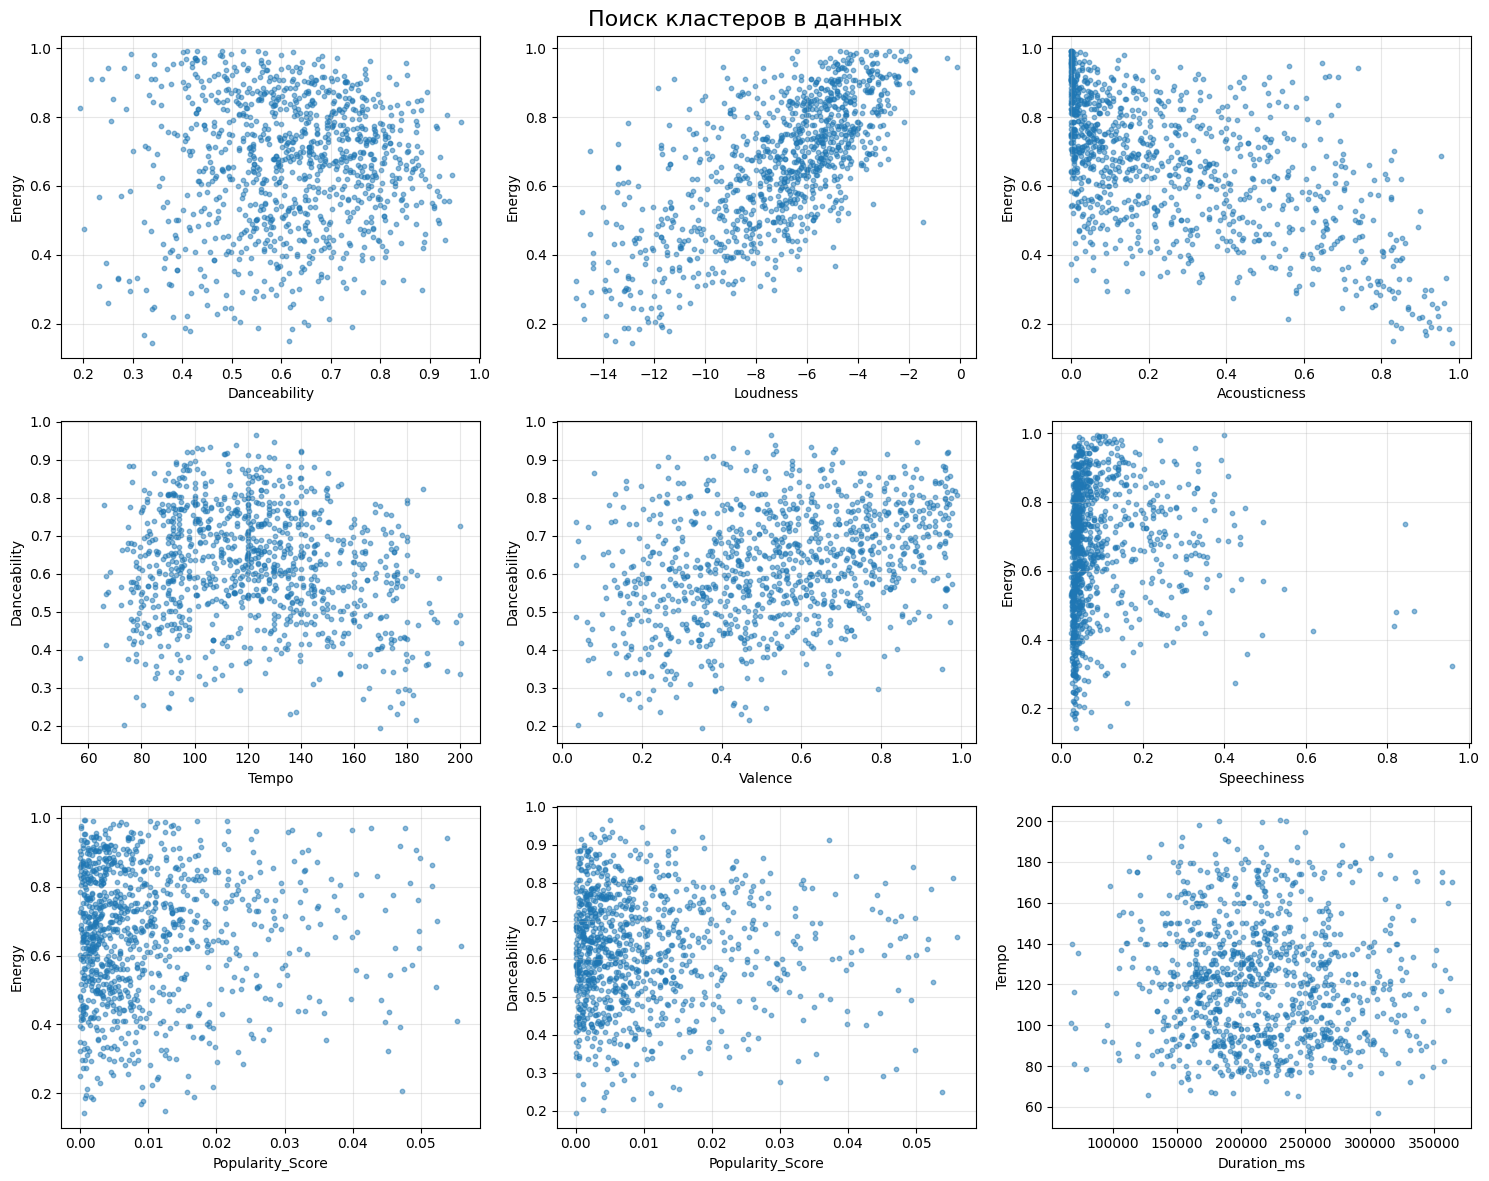

In [51]:
# 8. Визуализация данных и поиск кластеров (п.3 задания)
print("\n8. ВИЗУАЛИЗАЦИЯ ДАННЫХ И ПОИСК КЛАСТЕРОВ")

# Создаем scatter plot матрицу для поиска естественных кластеров
if 'Stream' in ds.columns:
    fig, axes = plt.subplots(3, 3, figsize=(15, 12))
    fig.suptitle('Поиск кластеров в данных', fontsize=16)
    
    # Параметры для scatter plots
    scatter_pairs = [
        ('Danceability', 'Energy', 0, 0),
        ('Loudness', 'Energy', 0, 1),
        ('Acousticness', 'Energy', 0, 2),
        ('Tempo', 'Danceability', 1, 0),
        ('Valence', 'Danceability', 1, 1),
        ('Speechiness', 'Energy', 1, 2),
        ('Popularity_Score', 'Energy', 2, 0),
        ('Popularity_Score', 'Danceability', 2, 1),
        ('Duration_ms', 'Tempo', 2, 2)
    ]
    
    for x_col, y_col, i, j in scatter_pairs:
        if x_col in ds.columns and y_col in ds.columns:
            # Берем случайную выборку для лучшей визуализации
            sample_size = min(1000, len(ds))
            sample_ds = ds.sample(sample_size, random_state=42)
            
            axes[i, j].scatter(
                sample_ds[x_col], 
                sample_ds[y_col], 
                alpha=0.5, 
                s=10
            )
            axes[i, j].set_xlabel(x_col)
            axes[i, j].set_ylabel(y_col)
            axes[i, j].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

In [52]:
# 9. Подготовка данных для K-means (п.4 задания)
print("\n9. ПОДГОТОВКА ДАННЫХ ДЛЯ K-MEANS")

# Выбираем ключевые признаки для кластеризации
features_for_clustering = [
    'Danceability', 'Energy', 'Loudness', 'Speechiness',
    'Acousticness', 'Instrumentalness', 'Liveness',
    'Valence', 'Tempo'
]

# Отбираем только существующие колонки
features_for_clustering = [col for col in features_for_clustering if col in ds.columns]


print(f"Признаки для кластеризации: {features_for_clustering}")
    
# Создаем датафрейм с выбранными признаками
X = ds[features_for_clustering].copy()
    
# Удаляем оставшиеся пропуски
X = X.dropna()
    
# Масштабируем данные
scaler = StandardScaler()
X_scaled = pd.DataFrame(
    scaler.fit_transform(X),
    columns=features_for_clustering,
    index=X.index
)
    
print(f"Размер данных для кластеризации: {X_scaled.shape}")


9. ПОДГОТОВКА ДАННЫХ ДЛЯ K-MEANS
Признаки для кластеризации: ['Danceability', 'Energy', 'Loudness', 'Speechiness', 'Acousticness', 'Instrumentalness', 'Liveness', 'Valence', 'Tempo']
Размер данных для кластеризации: (13306, 9)



10. ОПРЕДЕЛЕНИЕ ОПТИМАЛЬНОГО ЧИСЛА КЛАСТЕРОВ


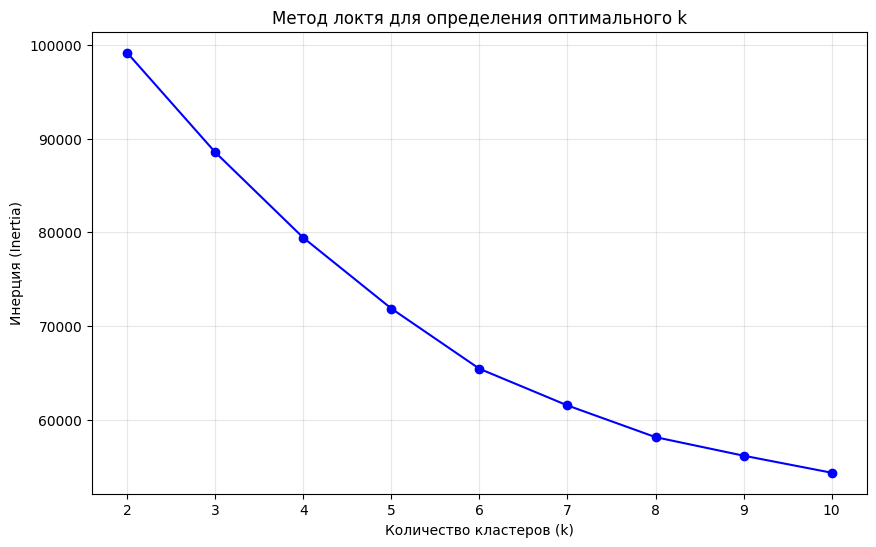

In [53]:
# 10. Определение оптимального числа кластеров (метод локтя)
print("\n10. ОПРЕДЕЛЕНИЕ ОПТИМАЛЬНОГО ЧИСЛА КЛАСТЕРОВ")
    
inertia_values = []
k_range = range(2, 11)
    
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_scaled)
    inertia_values.append(kmeans.inertia_)
    
# График метода локтя
plt.figure(figsize=(10, 6))
plt.plot(k_range, inertia_values, 'bo-')
plt.xlabel('Количество кластеров (k)')
plt.ylabel('Инерция (Inertia)')
plt.title('Метод локтя для определения оптимального k')
plt.grid(True, alpha=0.3)
plt.show()

In [55]:
# 11. Применение K-means с оптимальным k
print("\n11. ПРИМЕНЕНИЕ K-MEANS КЛАСТЕРИЗАЦИИ")
    
# Определяем оптимальное k (можно выбрать визуально по графику)
optimal_k = 6  # Измените это значение после анализа графика
    
# Создаем и обучаем модель K-means
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
cluster_labels = kmeans.fit_predict(X_scaled)
    
# Добавляем метки кластеров к данным
ds_clustered = ds.loc[X_scaled.index].copy()
ds_clustered['Cluster'] = cluster_labels
    
print(f"Кластеризация завершена. Создано {optimal_k} кластеров.")
print("\nРаспределение треков по кластерам:")
print(ds_clustered['Cluster'].value_counts().sort_index())


11. ПРИМЕНЕНИЕ K-MEANS КЛАСТЕРИЗАЦИИ
Кластеризация завершена. Создано 6 кластеров.

Распределение треков по кластерам:
Cluster
0    4479
1    2818
2     857
3    3206
4     466
5    1480
Name: count, dtype: int64



12. АНАЛИЗ ХАРАКТЕРИСТИК КЛАСТЕРОВ


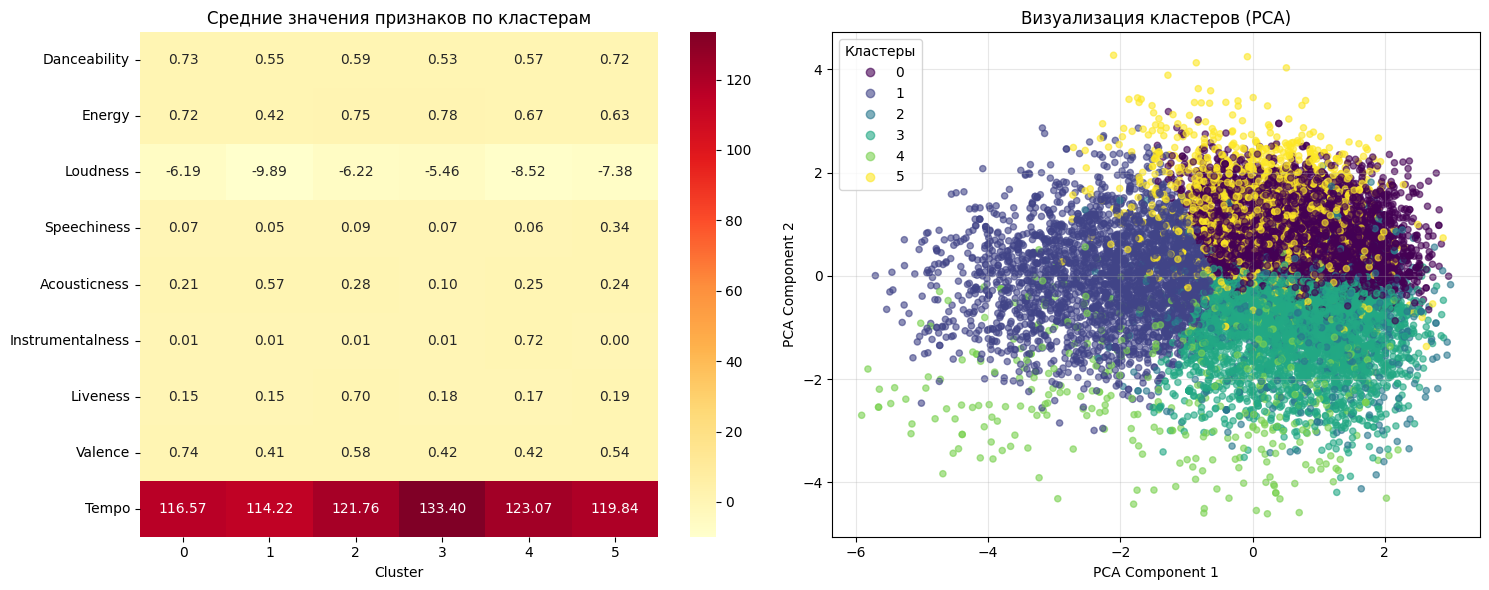

In [56]:
# 12. Анализ характеристик кластеров
print("\n12. АНАЛИЗ ХАРАКТЕРИСТИК КЛАСТЕРОВ")
    
# Средние значения по кластерам
cluster_means = ds_clustered.groupby('Cluster')[features_for_clustering].mean()
    
fig, axes = plt.subplots(1, 2, figsize=(15, 6))
    
# Heatmap средних значений по кластерам
sns.heatmap(cluster_means.T, annot=True, fmt='.2f', cmap='YlOrRd', ax=axes[0])
axes[0].set_title('Средние значения признаков по кластерам')
    
# Визуализация кластеров в 2D (PCA для уменьшения размерности)
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)
    
scatter = axes[1].scatter(
    X_pca[:, 0], 
    X_pca[:, 1], 
    c=cluster_labels, 
    cmap='viridis', 
    alpha=0.6,
    s=20
)
axes[1].set_xlabel('PCA Component 1')
axes[1].set_ylabel('PCA Component 2')
axes[1].set_title('Визуализация кластеров (PCA)')
axes[1].legend(*scatter.legend_elements(), title="Кластеры")
axes[1].grid(True, alpha=0.3)
    
plt.tight_layout()
plt.show()

In [57]:
# 13. Интерпретация кластеров
print("\n13. ИНТЕРПРЕТАЦИЯ КЛАСТЕРОВ")
print("=" * 50)
    
for cluster_id in range(optimal_k):
    cluster_data = ds_clustered[ds_clustered['Cluster'] == cluster_id]
        
    print(f"\nКластер {cluster_id}: {len(cluster_data)} треков ({len(cluster_data)/len(ds_clustered)*100:.1f}%)")
    print("-" * 30)
        
    # Находим топ-3 признака, которые наиболее отличают этот кластер
    cluster_mean = cluster_data[features_for_clustering].mean()
    overall_mean = ds_clustered[features_for_clustering].mean()
        
    differences = (cluster_mean - overall_mean).abs().sort_values(ascending=False)
    top_features = differences.head(3).index.tolist()
        
    print(f"Наиболее отличающие признаки: {', '.join(top_features)}")
        
    for feature in top_features:
        clust_val = cluster_mean[feature]
        overall_val = overall_mean[feature]
        diff_pct = ((clust_val - overall_val) / overall_val * 100)
        print(f"  {feature}: {clust_val:.3f} (в среднем: {overall_val:.3f}, разница: {diff_pct:+.1f}%)")
        
    if 'Popularity_Score' in cluster_data.columns:
        avg_popularity = cluster_data['Popularity_Score'].mean()
        print(f"Средняя популярность: {avg_popularity:.3f}")
        
    print()


13. ИНТЕРПРЕТАЦИЯ КЛАСТЕРОВ

Кластер 0: 4479 треков (33.7%)
------------------------------
Наиболее отличающие признаки: Tempo, Loudness, Valence
  Tempo: 116.574 (в среднем: 121.055, разница: -3.7%)
  Loudness: -6.194 (в среднем: -7.015, разница: -11.7%)
  Valence: 0.737 (в среднем: 0.549, разница: +34.1%)
Средняя популярность: 0.010


Кластер 1: 2818 треков (21.2%)
------------------------------
Наиболее отличающие признаки: Tempo, Loudness, Acousticness
  Tempo: 114.217 (в среднем: 121.055, разница: -5.6%)
  Loudness: -9.892 (в среднем: -7.015, разница: +41.0%)
  Acousticness: 0.569 (в среднем: 0.270, разница: +111.0%)
Средняя популярность: 0.011


Кластер 2: 857 треков (6.4%)
------------------------------
Наиболее отличающие признаки: Loudness, Tempo, Liveness
  Loudness: -6.220 (в среднем: -7.015, разница: -11.3%)
  Tempo: 121.764 (в среднем: 121.055, разница: +0.6%)
  Liveness: 0.703 (в среднем: 0.199, разница: +253.3%)
Средняя популярность: 0.010


Кластер 3: 3206 треков (24.1